# SWSN - EaT-PIM with simplified ingredients and ingredient metadata

Bartosz Stachowiak 148259<br>
Andrzej Kajdasz 148273

## 1. Introduction
After reading [EaT-PIM: Substituting Entities in Procedural Instructions using Flow Graphs and Embeddings (Sola S. Shirai, HyeongSik Kim)](https://dspace.rpi.edu/bitstream/handle/20.500.13015/6364/ISWC_EaT_PIM.pdf?sequence=1&isAllowed=y&fbclid=IwAR3RaVCT2_kb0T5NmVNs2ulIxjWkbDBu8T9wfUrIk7pSrjLcRQEeA6BqVkg) we noticed a room for improvement in the appraoch. We hypothesize that we could improve the results by incorporating other information besides the ingredients themselves to improve the quality of the suggestions.
<br><br>
The first and most important task for us is to incorporate ingredient metadata in substitute prediction. The proposed model utilizes only the contextual information about the ingredient from recipes, which is not always accurate (completely different ingredients might be prepared in similar ways but do not taste alike). To improve the quality of the prediction, we could incorporate the metadata about individual ingredients (e.g. taste, type) and make a prediction as a combination of the two sources. The plan for us is to describe the metadata in form of a feature matrix (one-hot encoded), combine similarity metric between the missing ingredient and its alternatives, combine the metric with paper's original approach using weights, find most appropriate replacements
<br><br>
The second proposition equally important is to simplify the ingredients to get more informative predictions. The authors seem to have used very granular distinction between individual ingredients, which sometimes give very unhelpful substitution propositions (e.g. pork => boneless pork). Simplifying the distinction and grouping very similar ingredients could help with more insightful predictions. To achieve such results we will prune any modifiers from existing ingredients (e.g. boneless pork), aggregate ingredients to their simplest form.

We strongly believe that with these two changes, we will be able to improve upon the initial solution.

## 2. EDA on original dataset

Raw data are taken from [kaggle - Food.com Recipes and Interactions dataset](https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions).

This dataset was created by scraping over 230k recipies from [Food.com](food.com).

In [1]:
import itertools
import collections

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/RAW_recipes.csv')
df.set_index('id', inplace=True)
df.head()

,name,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
id,,,,,,,,,,,
137739,arriba baked winter squash mexican style,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
31490,a bit different breakfast pizza,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
112140,all in the kitchen chili,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
59389,alouette potatoes,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
44061,amish tomato ketchup for canning,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


### 2.1. Column Description

The dataset consists of recipies, each described by the following:
- **name** - name of the recipe, string, lowercase 
- **id** - id of the recipe, int
- **minutes** - time needed to prepare the recipe in minutes, int
- **contributor_id** - id of the contributor, int
- **submitted** - date of submission, string, format: YYYY-MM-DD
- **tags** - tags of the recipe, list of lowercase strings
- **nutrition** - nutrition information, list of 7 floats:
  - **calories (#)**
  - **total fat (PDV)**
  - **sugar (PDV)**
  - **sodium (PDV)**
  - **protein (PDV)**
  - **saturated fat (PDV)**
  - **carbohydrates (PDV)**
- **n_steps** - number of steps in the recipe, int
- **steps** - steps of the recipe, list of strings
- **description** - description of the recipe, string
- **ingredients** - ingredients of the recipe, list of strings
- **n_ingredients** - number of ingredients in the recipe, int

The authors of the paper have used only the **ingredients** and **steps** columns, which we will also use in our approach.

In [3]:
def parse_string_list(string_list: str) -> list[str]:
    return [token[1:-1] for token in string_list[1:-1].replace(" , ", "; ").split(", ")]

ingredients = df.ingredients.apply(parse_string_list).tolist()
steps = df.steps.apply(parse_string_list).tolist()

### 2.2. Ingredients

On average, each recipe has 9 ingredients.

In [4]:
df.n_ingredients.describe()

count    231637.000000
mean          9.051153
std           3.734796
min           1.000000
25%           6.000000
50%           9.000000
75%          11.000000
max          43.000000
Name: n_ingredients, dtype: float64

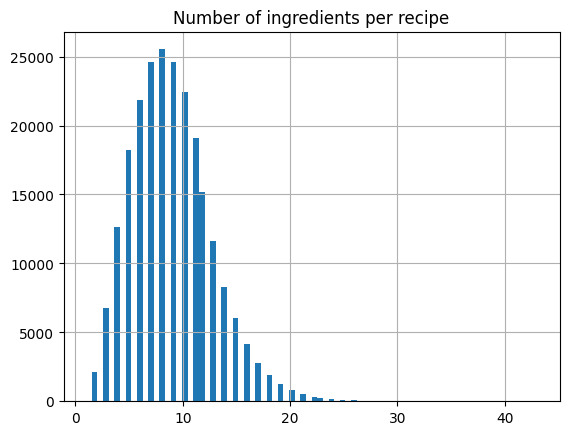

In [5]:
df.n_ingredients.hist(bins=80)
plt.title("Number of ingredients per recipe")
plt.show()

In [6]:
ingredient_counts = collections.Counter(itertools.chain.from_iterable(ingredients))

print("Total number of ingredients:", len(ingredient_counts))

Total number of ingredients: 14917


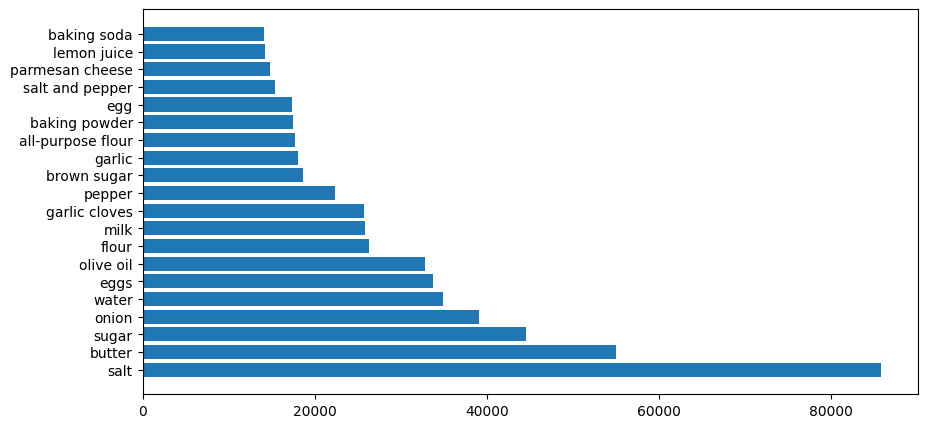

In [7]:
most_common = ingredient_counts.most_common(20)
plt.figure(figsize=(10, 5))
plt.barh([ingredient for ingredient, _ in most_common], [count for _, count in most_common])
plt.show()

In [8]:
counts_arr = np.array(tuple(ingredient_counts.values()))
used_only_once_count = (counts_arr < 2).sum()
used_less_than_5_count = (counts_arr < 5).sum()

print(f"{used_only_once_count / len(ingredient_counts) * 100:.2f}% of ingredients are used only in one recipe")
print(f"{used_less_than_5_count / len(ingredient_counts) * 100:.2f}% of ingredients are used in less than 5 recipes")

23.76% of ingredients are used only in one recipe
46.42% of ingredients are used in less than 5 recipes


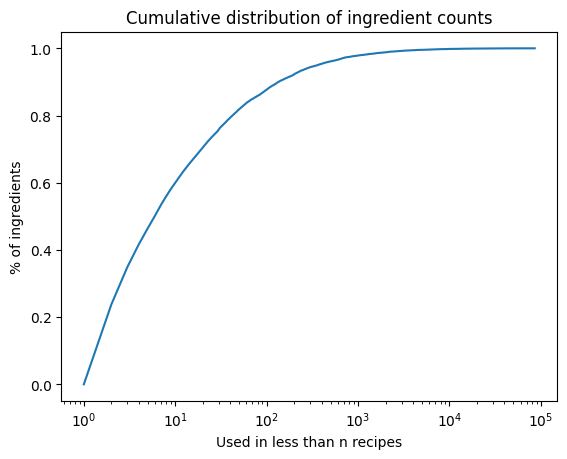

In [18]:
x = [i for i in range(1, counts_arr.max() + 1)]
y = [(counts_arr < i).sum() / counts_arr.shape[0] for i in x]
plt.plot(x, y)
plt.xscale('log')
plt.title("Cumulative distribution of ingredient counts")
plt.xlabel("Used in less than n recipes")
plt.ylabel("% of ingredients")
plt.show()

Many ingredients are very sparsly used, which is a problem for our approach. They are unlikely to be useful in the prediction, but some of them might be grouped to some more general ingredients. Some examples of such ingredients are:

In [158]:
for ing in list(ingredient_counts.keys())[-10:]:
    print(ing)

low-fat low-sodium condensed cream of tomato soup
thousand island sandwich spread
pesto garlic tortillas
roasted red pepper pesto
seasoned rice vinegar with roasted garlic
apricot jell-o
rosarita premium whole black beans
hunt's fire roasted diced tomatoes
skinless halibut fillet
nepitella


### 2.3. Steps

On average, each recipe has 10 steps.

In [159]:
df.n_steps.describe()

count    231637.000000
mean          9.765499
std           5.995128
min           0.000000
25%           6.000000
50%           9.000000
75%          12.000000
max         145.000000
Name: n_steps, dtype: float64

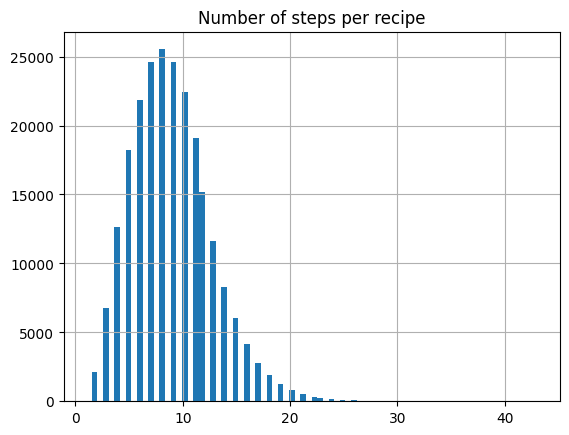

In [160]:
df.n_ingredients.hist(bins=80)
plt.title("Number of steps per recipe")
plt.show()

Example of a recipe:

In [161]:
for i, step in enumerate(steps[0]):
    print(f"{i+1:>4}. {step}")

   1. make a choice and proceed with recipe
   2. depending on size of squash; cut into half or fourths
   3. remove seeds
   4. for spicy squash; drizzle olive oil or melted butter over each cut squash piece
   5. season with mexican seasoning mix ii
   6. for sweet squash; drizzle melted honey; butter; grated piloncillo over each cut squash piece
   7. season with sweet mexican spice mix
   8. bake at 350 degrees; again depending on size; for 40 minutes up to an hour; until a fork can easily pierce the skin
   9. be careful not to burn the squash especially if you opt to use sugar or butter
  10. if you feel more comfortable; cover the squash with aluminum foil the first half hour; give or take; of baking
  11. if desired; season with salt
